### Peak Mem vs. Operation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
# hyperparams
batch_size = 60
model_name = "torchbenchmark.models.hf_Bert.Model"

In [60]:
# Open graph_prof.txt as a pandas dataframe
df_before = pd.read_csv(
    f"results/graph_prof_before_checkpoint_{model_name}_{batch_size}.txt"
)
df_after = pd.read_csv(
    f"results/graph_prof_after_checkpoint_{model_name}_{batch_size}.txt"
)
df_before

,Node,Node Type,Target,Size (B),Avg runtime (ms),Peak Memory (B),Parameter Memory (B),Gradient Memory (B),Activation Memory (B),Other Memory (B),Recomputation Memory (B),Swap Time (ms)
0,ones,PARAM,torch.ops.aten.ones.default,122880,0.117419,1327733248,1327610368,0,0,0,0,NaN
1,slice_1,OTHER,torch.ops.aten.slice.Tensor,4096,0.056320,1327733248,1327610368,0,0,4096,0,NaN
2,expand,ACT,torch.ops.aten.expand.default,4096,0.045397,1327733248,1327610368,0,4096,4096,0,0.065024
3,slice_2,PARAM,torch.ops.aten.slice.Tensor,122880,0.029355,1327733248,1327610368,0,4096,0,0,NaN
4,unsqueeze,PARAM,torch.ops.aten.unsqueeze.default,122880,0.037888,1327733248,1327610368,0,4096,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4126,copy__812,OTHER,torch.ops.aten.copy_.default,3072,0.042667,1421502464,1327610368,0,0,1408164864,0,NaN
4127,copy__813,OTHER,torch.ops.aten.copy_.default,3072,0.042325,1421499392,1327610368,0,0,1408164864,0,NaN
4128,copy__814,OTHER,torch.ops.aten.copy_.default,93763584,0.145408,1421496320,1327610368,0,0,1501925376,0,NaN
4129,copy__815,OTHER,torch.ops.aten.copy_.default,122368,0.044715,1327732736,1327610368,0,0,1314520576,0,NaN


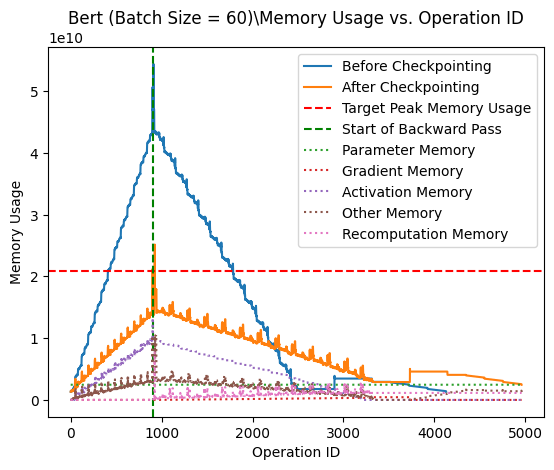

In [100]:
# PLOT BOTH DFs ON THE SAME PLOT
plt.plot(df_before["Peak Memory (B)"], label="Before Checkpointing")
plt.plot(df_after["Peak Memory (B)"], label="After Checkpointing")

# Plot target peak memory usage
plt.axhline(20937965568, color="red", linestyle="--", label="Target Peak Memory Usage")
# Plot start of backward pass
sep_backward_idx = df_after[df_after["Node"] == "sep_backward"].index[0]
plt.axvline(
    sep_backward_idx, color="green", linestyle="--", label="Start of Backward Pass"
)

# Plot memory usage by type of node on the same plot
plt.plot(df_after["Parameter Memory (B)"], linestyle=":", label="Parameter Memory")
plt.plot(df_after["Gradient Memory (B)"], linestyle=":", label="Gradient Memory")
plt.plot(df_after["Activation Memory (B)"], linestyle=":", label="Activation Memory")
plt.plot(df_after["Other Memory (B)"], linestyle=":", label="Other Memory")
plt.plot(
    df_after["Recomputation Memory (B)"], linestyle=":", label="Recomputation Memory"
)


plt.xlabel("Operation ID")
plt.ylabel("Memory Usage")
plt.title("Bert (Batch Size = 60)\nMemory Usage vs. Operation ID")
plt.legend()

plt.show()


### Before vs. After Peak Mem

In [88]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
# Go through all the files in the results folder with the format results_*.csv
# and concatenate them into a single dataframe
df = None
for file in os.listdir("results"):
    if file.endswith(".csv") and file.startswith("results_"):
        # Open the file as a pandas dataframe
        row_df = pd.read_csv(os.path.join("results", file))
        if df is None:
            df = row_df
        else:
            df = pd.concat([df, row_df])
df = df.reset_index()

# Change torchbenchmark.models.hf_Bert.Model to Bert
df["Model"] = df["Model"].str.replace("torchbenchmark.models.hf_Bert.Model", "Bert")
df["Model"] = df["Model"].str.replace(
    "torchbenchmark.models.hf_Bert.Model (No AC)", "Bert (No AC)"
)

# Create a separate column for whether the model is no ac or not
df["No AC"] = df["Model"].str.contains("No AC")
# Remove the No AC from the Model column
df["Model"] = df["Model"].str.replace(" (No AC)", "")

# Group by Model and Batch Size and get the mean of the other two columns
df = df.groupby(["Model", "Batch Size", "No AC"]).mean().reset_index()
df.loc[df["Model"] == "Bert"]

,Model,Batch Size,No AC,index,Run Time,Peak Memory
0,Bert,1,False,0.0,53.452801,3.906821e+09
1,Bert,2,False,0.0,76.557996,3.917493e+09
2,Bert,4,False,0.0,127.752192,4.727962e+09
3,Bert,8,False,0.0,227.332774,8.102722e+09
4,Bert,8,True,0.0,227.438934,8.103640e+09
5,Bert,10,False,0.0,197.830018,9.851313e+09
6,Bert,10,True,0.0,466.536118,9.855572e+09
7,Bert,16,False,0.0,426.199382,1.487983e+10
8,Bert,16,True,0.0,426.764628,1.487983e+10
9,Bert,20,False,0.0,512.842414,1.826750e+10


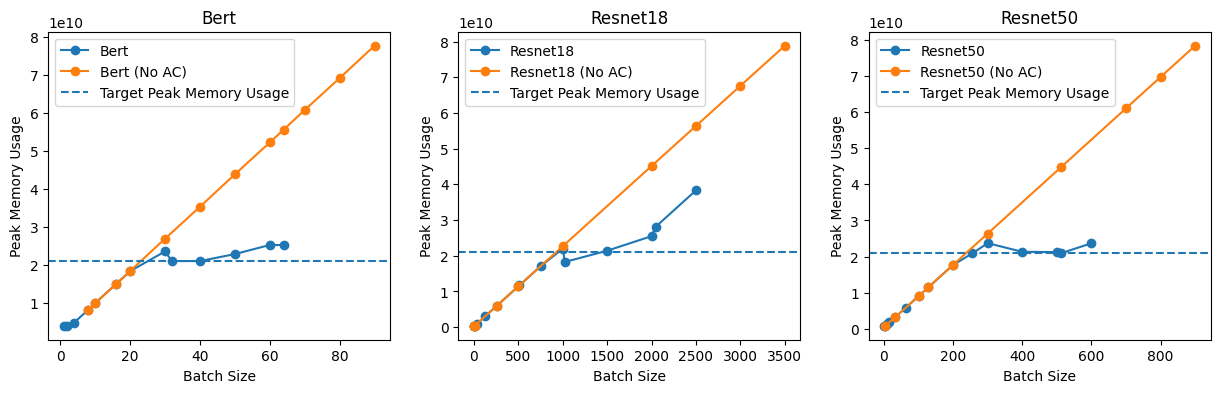

In [97]:
# Plot the peak memory usage vs. batch size for each model
# Put each model in a different subplot
assert df is not None
fig, axes = plt.subplots(nrows=1, ncols=len(df["Model"].unique()), figsize=(15, 4))
for i, model in enumerate(df["Model"].unique()):
    # Plot the no ac and ac models in different colors
    df_no_ac = df[df["No AC"] == False]
    df_ac = df[df["No AC"] == True]
    axes[i].plot(
        df_no_ac[df_no_ac["Model"] == model]["Batch Size"],
        df_no_ac[df_no_ac["Model"] == model]["Peak Memory"],
        label=model,
        marker="o",
    )
    axes[i].plot(
        df_ac[df_ac["Model"] == model]["Batch Size"],
        df_ac[df_ac["Model"] == model]["Peak Memory"],
        label=model + " (No AC)",
        marker="o",
    )
    axes[i].set_xlabel("Batch Size")
    axes[i].set_ylabel("Peak Memory Usage")
    axes[i].set_title(model)
    # Add horizontal line for memory limit (1/4 of total GPU memory)
    axes[i].axhline(20937965568, linestyle="--", label="Target Peak Memory Usage")
    axes[i].legend()


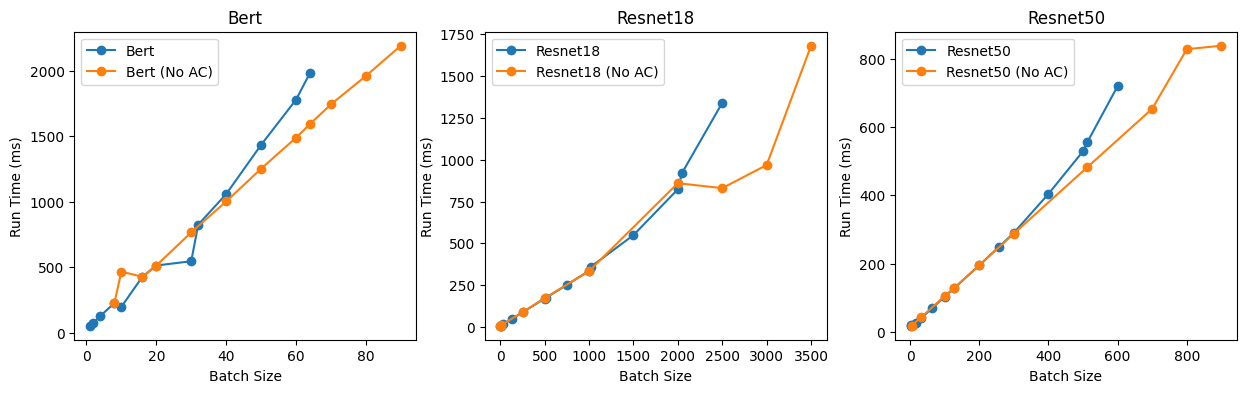

In [98]:
# Plot the run time vs. batch size for each model
# Put each model in a different subplot
assert df is not None
fig, axes = plt.subplots(nrows=1, ncols=len(df["Model"].unique()), figsize=(15, 4))
for i, model in enumerate(df["Model"].unique()):
    # Plot the no ac and ac models in different colors
    df_no_ac = df[df["No AC"] == False]
    df_ac = df[df["No AC"] == True]
    axes[i].plot(
        df_no_ac[df_no_ac["Model"] == model]["Batch Size"],
        df_no_ac[df_no_ac["Model"] == model]["Run Time"],
        label=model,
        marker="o",
    )
    axes[i].plot(
        df_ac[df_ac["Model"] == model]["Batch Size"],
        df_ac[df_ac["Model"] == model]["Run Time"],
        label=model + " (No AC)",
        marker="o",
    )
    axes[i].set_xlabel("Batch Size")
    axes[i].set_ylabel("Run Time (ms)")
    axes[i].set_title(model)
    axes[i].legend()